<a href="https://colab.research.google.com/github/whistle-hikhi/K-nearest-neighbors/blob/main/KD_tree_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvdia-smi

/bin/bash: line 1: nvdia-smi: command not found


In [2]:
%load_ext cuml.accel

[2025-04-01 05:40:33.514] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-04-01 05:41:00.409] [CUML] [info] cuML: Installed accelerator for umap.
[2025-04-01 05:41:00.504] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-04-01 05:41:00.504] [CUML] [info] cuML: Successfully initialized accelerator.


In [3]:
import numpy as np
from collections import namedtuple
import heapq

In [13]:
Node = namedtuple('Node', ['point', 'value', 'left', 'right'])

In [14]:
class KDTreeKNN:
  def __init__(self, k=3):
    self.k = k
    self.root = None
    self.dim = None

  def build_tree(self, points, values, depth=0):
    if len(points) == 0:
      return None

    k = points.shape[1]
    axis = depth % k

    sorted_idx = np.argsort(points[:, axis])
    points = points[sorted_idx]
    values = values[sorted_idx]
    median = len(points) // 2

    return Node(
        point=points[median],
        value=values[median],
        left=self.build_tree(points[:median], values[:median], depth + 1),
        right=self.build_tree(points[median + 1:], values[median + 1:], depth + 1)
    )


  def fit(self, X, y):
    self.dim = X.shape[1]
    self.root = self.build_tree(X, y)

  def distance(self, p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

  def nearest_neighbors(self, node, point, k, depth=0, neighbors=None):
    if neighbors is None:
      neighbors = []
    if node is None:
      return neighbors
    axis = depth % self.dim
    dist = self.distance(point, node.point)

    heapq.heappush(neighbors, (-dist, node.value))

    if len(neighbors) > k:
      heapq.heappop(neighbors)

    if point[axis] < node.point[axis]:
      near, far = node.left, node.right
    else:
      near, far = node.right, node.left


    neighbors = self.nearest_neighbors(near, point, k , depth + 1, neighbors)

    if len(neighbors) < k or - neighbors[0][0] > abs(point[axis] - node.point[axis]):
      neighbors = self.nearest_neighbors(far, point, k, depth + 1, neighbors)

    return neighbors

  def predict(self, X_test):
    predictions = []
    for point in X_test:
      neighbors = self.nearest_neighbors(self.root, point, self.k)
      pred = np.mean([val for _, val in neighbors])
      predictions.append(pred)

    return np.array(predictions)

In [15]:
np.random.seed(16)

X_train = np.array([
        [1, 2], [2, 3], [3, 1],
        [6, 5], [7, 8], [8, 7]
    ])

y_train = np.array([1.5, 2.0, 1.8, 3.5, 4.0, 3.8])

X_test = np.array([[4, 3], [5, 6]])

In [16]:
knn = KDTreeKNN(k=3)
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)

In [17]:
print('Test points:', X_test)
print('Predictions:', predictions)

Test points: [[4 3]
 [5 6]]
Predictions: [2.43333333 3.76666667]


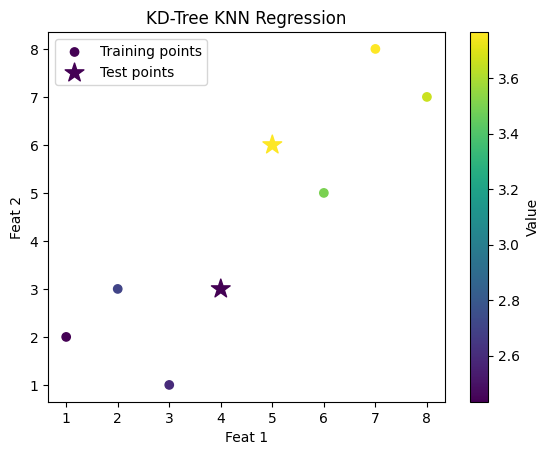

In [18]:
import matplotlib.pyplot as plt

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', label='Training points')
plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions, cmap='viridis', marker='*', s=200, label='Test points')
plt.colorbar(label='Value')
plt.legend()
plt.title('KD-Tree KNN Regression')
plt.xlabel('Feat 1')
plt.ylabel('Feat 2')
plt.show()